

## PART 1 (20%)

Use “midterm_partone.csv” file that contains the stock-return information of small retailers (the same as the one we used in Session
5). Suppose that an industry expert (e.g., David Berman) claims that there is a bias in moment conditions of instrumental variables such that
$Z^T(Y - XB) = 𝛿 \begin{bmatrix}
1 \\
1 \\
1 \\
\end{bmatrix} $, where $𝛿$,the delta term, has a non-zero value, $Z$ is a matrix of instruments, $Y$ is the vector of observations, $X$ is the matrix of explanatory variables, $B$ is the vector of coefficients.





In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mp
import statsmodels.api as sm

from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.sandbox.regression.gmm import GMM

In [ ]:
df1 = pd.read_csv("/content/midterm_partone.csv")

In [ ]:
df1.head()

,Constant,Stock Change,Inventory Turnover,Operating Profit,Interaction Effect,Current Ratio,Quick Ratio,Debt Asset Ratio
0,1,0.870332,1.795946,0.115846,0.208053,1.672527,0.255171,0.473317
1,1,-0.047347,1.395501,0.436967,0.609788,1.637261,0.221763,0.489967
2,1,0.001176,1.664563,0.541016,0.900555,1.640619,0.189141,0.374269
3,1,-0.901200,1.605738,0.539399,0.866133,1.436221,0.131944,0.224399
4,1,-0.176353,1.591451,0.539938,0.859285,1.433140,0.183095,0.213446


In [ ]:
# df1.info(); df1.describe()

### 1.
Update the GMM model that we discussed in class by incorporating the 𝛿 term to the instrumental-variable moment expressions.

In [ ]:
class BiasedIVGMM(GMM):
    def momcond(self, params):
        beta = params[:-1]  # Coefficients for the exogenous variables
        delta = params[-1]  # Bias term or delta

        # Calculate the residuals/errors under OLS model
        residuals = self.endog - np.dot(self.exog, beta)

        # Calculate the moments for the exogenous variables
        moments_exog = residuals[:, None] * self.exog

        # Calculate the moments for the instruments
        moments_instr = residuals[:, None] * self.instrument - delta

        # Combine the moments into one array
        moments = np.hstack([moments_exog, moments_instr])

        return moments


### 2.
By analyzing the GMM summary table and test statistics of coefficients, determine if the industry expert's claim is statistically justified.



In [ ]:
# dependent variable: Y
y_vals = np.array(df1["Stock Change"])

# endogenous variable and exogenous variables: X
x_vals = np.array(df1[["Constant", "Inventory Turnover","Operating Profit",
                        "Interaction Effect"]])
# instruments: Z
iv_vals = np.array(df1[["Current Ratio","Quick Ratio","Debt Asset Ratio"]])

In [ ]:
# Number of exogenous variables and instruments
num_exog = x_vals.shape[1]
num_instr = iv_vals.shape[1]

# Initial parameters: betas for exogenous variables and 1 delta
beta0 = np.array([0.1, 0.1, 0.1, 0.1, 0.1])

res = BiasedIVGMM(endog=y_vals, exog=x_vals, instrument=iv_vals,
                  k_moms=num_exog + num_instr,
                  k_params=num_exog + 1).fit(start_params=beta0)

# Print the summary of the results
print(res.summary())


Optimization terminated successfully.
         Current function value: 0.000095
         Iterations: 12
         Function evaluations: 16
         Gradient evaluations: 16
Optimization terminated successfully.
         Current function value: 0.001753
         Iterations: 8
         Function evaluations: 11
         Gradient evaluations: 11
Optimization terminated successfully.
         Current function value: 0.001735
         Iterations: 7
         Function evaluations: 12
         Gradient evaluations: 12
Optimization terminated successfully.
         Current function value: 0.001735
         Iterations: 5
         Function evaluations: 9
         Gradient evaluations: 9
Optimization terminated successfully.
         Current function value: 0.001735
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
                             BiasedIVGMM Results                              
Dep. Variable:                      y   Hansen J:                    

$$Stock Change=−0.0011+0.0004×Inventory Turnover−0.1191×Operating Profit+0.0014×Interaction Effect+0.0003$$

**Coefficients**


- $p_{0}$: -0.0011  

The value of Stock Change is -0.0011 when all other independent variables are 0.

- $p_{1}$: 0.0004   

One-unit increase in Inventory Turnover, holding all other variables constant Stock Change is expected to increase by 0.0004 units

- $p_{2}$: -0.1191

One-unit increase in Opearting Profit, holding all other variables constant. Stock Change is expected to decrease by 0.1191 units

- $p_{3}$: 0.0014  

Every additional unit increase in Operating Profit, the effect of Inventory Turnover on Stock Change increases by 0.0014 units.

- $p_{4}$: 0.0003

The coefficient of bias term δ of 0.0003 is small, suggests that any potential bias in the OLS estimates due to the IVs is minimal.

**P-values**





*   $p_{0}$:0.949   

The constant term is not significantly different from zero since the p-value is larger than 0.05.

*   $p_{1}$: 0.317

The Inventory Turnover is not significantly different from zero since the p-value is larger than 0.05.


- $p_{2}$:0.000  

The Operating Profit is statistical significant due to a extreme small.p-value.


- $p_{3}$: 0.000  

The Interaction term is statistical significant due to a extreme small.p-value
- $p_{4}$: 0.895  

The bias term δ is not statistical significant from zero since the p-value is larger than 0.05.Thus, there might not have a systematic biasin the moment conditions.

The Hansen J statistic of 2.942 with a p-value of 0.230 indicates that we cannot reject the null hypothesis that the instrument is valid, such that the instrument is appropriately uncorrelated with the error term.


Based on the statistical evidence from the GMM summary results, David Berman's claim about a bias in the moment conditions is not correct. The findings imply that the instruments are valid, and there is no significant bias present in the moment conditions.

## Part 2 (80%)

A global bank that started to operate in Turkey in 2000s decided to expand its presence in small
cities and even villages. The executives spent long times to develop an expansion strategy by
focusing on how to attract customers in small cities, rather than big cities such as Istanbul,
because they expected less competition in those regions. The main challenge for such an
expansion was that many people living in small cities did not have even a bank account. According
to a World Bank report, for example, 1.7 billion adults in the world do not have any account in a
financial institution.


In small cities, people do not need a bank account for two reasons. First, online payments can be
made through GSM operators by sending an SMS, which is popular in Turkey
(https://www.ft.com/content/ce9227b0-129e-433a-b9fc-0744b163451b). Owing to the SMS
payment possibility, residents of a small Turkish city do not need a credit card nor a bank account.
The second reason is that credit applications in small cities are processed slowly in comparison
to big cities because the documents taken from a customer should be sent by post to main
branches in big cities where risk management experts approve or decline the applications. Being
aware of long processing times, the residents usually borrow money from their families or
friends, instead of going to a bank.


To attract new customers in small cities, the bank decided to automate the assessment of credit
applications. A team of experts by the bank used the credit score data and tested some
approaches. They helped the bank shorten the processing time for some group of customers. But
the involvement of risk management team is unavoidable to assess the application of some high-
risk customers. Therefore, the bank attracted new customers for some segments, while many
customers still stay unbanked. Use the dataset “midterm_parttwo.csv” to answer the questions.

In [ ]:
df2 = pd.read_csv("/content/midterm_parttwo.csv")

In [ ]:
df2.head()

,Years of Education after High School,Requested Credit Amount,Number of Dependents,Monthly Income,Monthly Expense,Marital Status,Credit Rating
0,1,Low,No dependent,Very low,Very low,Married,Positive
1,2,Low,No dependent,Very low,Very low,Single,Positive
2,1,Low,No dependent,Very low,Very low,Single,Positive
3,3,Low,No dependent,Very low,Very low,Married,Positive
4,3,Low,No dependent,Very low,Very low,Single,Negative


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8081 entries, 0 to 8080
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Years of Education after High School  8081 non-null   int64 
 1   Requested Credit Amount               8081 non-null   object
 2   Number of Dependents                  8081 non-null   object
 3   Monthly Income                        8081 non-null   object
 4   Monthly Expense                       8081 non-null   object
 5   Marital Status                        8081 non-null   object
 6   Credit Rating                         8081 non-null   object
dtypes: int64(1), object(6)
memory usage: 442.1+ KB


### 1.
Divide the dataset equally into two as training (50%) and test (50%) sets. Use the training set to fit a logistic regression model, where the credit rating is the dependent variable. Apply the model to the test set, and report the confusion matrix, recall, precision, and F1 score values.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Identifying the feature columns and the target column
feature_columns = df2.columns[:-1]  # all columns except the last one
target_column = df2.columns[-1]  # the last column: Credit Rating

# Separating the features and the target variable
X = df2[feature_columns]
y = df2[target_column]

# One-hot encode the categorical variables
encoder = OneHotEncoder(sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Split the dataset into a 50% train and 50% test set
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.5,
                                                    random_state=56)



In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score

# Initialize the logistic regression model
model = LogisticRegression(max_iter=1000)

# Fit the model on the training set
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

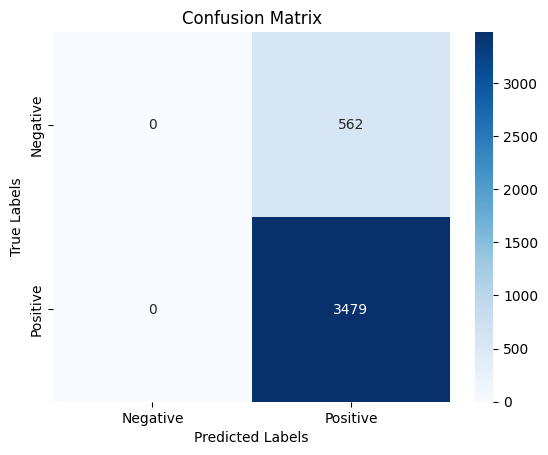

In [ ]:
# Calculate the confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

# Adding the labels and titles
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

# Display the confusion matrix
plt.show()

In [ ]:
# recall, precision, and F1 score
recall = recall_score(y_test, y_pred, pos_label='Positive')
print(f"The recall value is {recall:.2f}")


precision = precision_score(y_test, y_pred, pos_label='Positive')
print(f"The precision value is {precision:.2f}")


f1 = f1_score(y_test, y_pred, pos_label='Positive')
print(f"The f1 value is {f1:.2f}")

The recall value is 1.00
The precision value is 0.86
The f1 value is 0.93


The recall value is 1, which shows the model captures all of the positive cases w​hile the precision is 0.86 meaning that there are some false positive cases (predict as positive but incorrect predictions). The f1 value is 0.93, indicating the model perform well and good balance between precision and recall.
Regarding the confusion matrix, it seems there could be a class imbalance, thus, can try to adjust the threshold and recalculate the confusion matrix.

### 2.
Suppose that the bank decided to make the credit approval process more challenging such that only 15% of the applications would be granted. Calculate the threshold value for the prediction probability, so only 15% of the test set would get their applications approved. Then, update your confusion matrix, recall, precision, and F1 scores.


In [ ]:
# Get the prediction probabilities for the positive class again
y_probs = model.predict_proba(X_test)[:, 1]

# Since the logistic regression model's classes are in a specific order,
# we need to get that order to map probabilities to class labels correctly
labels = model.classes_

# Now we find the threshold that would give us the top 15% of this distribution
threshold = np.percentile(y_probs, 85)

# Use this threshold to convert probabilities to a binary outcome
y_pred_threshold = (y_probs >= threshold).astype('int')

# Map the binary outcomes to the original class labels
y_pred_labels = [labels[i] for i in y_pred_threshold]


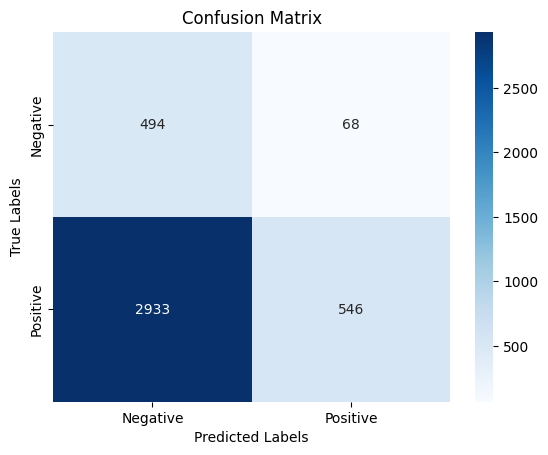

In [ ]:
# Calculate the confusion matrix, recall, precision, and F1 score using the new predictions
conf_matrix = confusion_matrix(y_test, y_pred_labels, labels=labels)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])

# Adding the labels and titles
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('Confusion Matrix')

# Display the confusion matrix
plt.show()

In [ ]:
recall = recall_score(y_test, y_pred_labels, pos_label='Positive')
precision = precision_score(y_test, y_pred_labels, pos_label='Positive')
f1_score = f1_score(y_test, y_pred_labels, pos_label='Positive')


print(f"The recall value is {recall:.2f}")
print(f"The precision value is {precision:.2f}")
print(f"The f1 value is {f1_score:.2f}")

The recall value is 0.16
The precision value is 0.89
The f1 value is 0.27


By setting the threshold to ensure that only the top 15% of applicants are approved, the model now demonstrates a higher precision. This means that the instances it classifies as approved are usually accurate. On the flip side, the model's recall has declined significantly, suggesting that it fails to detect a substantial number of actual approvable cases. Consequently, the F1 score, which harmonizes the precision and recall, has diminished because of the reduced recall. Such a result aligns with the intent to tighten the credit approval criteria, leading the model to predict approvals more cautiously.